## [Computational Social Science] Project 5: Natural Language Processing
**Group 3: Jose Aveldanes, Shruti Bathia, and Diana Casanova**

## 1. Introduction
In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [289]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.preprocessing import StandardScaler

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation , NMF

# gensim
import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#WordCloud for EDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#removing emojis
import re

#import emoji
#import scattertext as st

from sklearn.decomposition import PCA

##machine learning and classification part 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

##helps deal with the Spanish words issue with word corpus method
import nltk
#nltk.download('words')

## 2. Data

In [290]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
numpy.random.seed(44)
congress_tweets = congress_tweets.sample(frac=0.001, random_state=1)
congress_tweets = congress_tweets.reset_index(drop = True)
congress_tweets.head()
# COMPLETE - fill in this line of code with a sufficient number of tweets, depending on your computational resources
# COMPLETE congress_tweets = congress_tweets.sample(...)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## 3. Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [291]:
nlp = en_core_web_sm.load()

In [292]:
def remove_emojis(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" #emoticons  
        u"\U0001F300-\U0001F5FF" #symbols & pictographs 
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #flags(iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"   
        "]+", 
        flags=re.UNICODE,)
    return emoji_pattern.sub(r"", string)

In [293]:
congress_tweets['text_deEmojify'] = congress_tweets['text'].map(lambda x: remove_emojis(x))

In [294]:
print(congress_tweets.iloc[5]['text_deEmojify']) #checking to see if emojis were removed

RT @Johnson4Dallas This is the most accurate description of the current City of Dallas budget debate (and surrounding noise) that I have read thus far. Kudos to the author for helping to arm the residents of Dallas with actual facts instead of useless political gossip. https://texasscorecard.com/commentary/montoya-citizens-matter-not-city-hall-brawls/


In [295]:
#Removing new line
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('\n','')
#Removing New Line Breaks
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('•','')

In [296]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"amp", "RT", "today", "rt", "Today"}
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [297]:
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0      [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
1      [My, Twitter, Town, Hall, healthcare, begun, I...
2      [Scipio, Jones, ‘, fight, civil, rights, equal...
3      [There, better, time, ActOnClimate, EarthDay, ...
4      [I, understand, VA, problems, recruiting, qual...
                             ...                        
942    [Thank, air, traffic, controllers, flight, att...
943    [LawrenceGenHosp, new, coronavirus, community,...
944    [senatemajldr, If, House, musters, courage, st...
945    [It, important, support, policies, promote, pu...
946    [davidmgoodwin, CDCgov, It, argument, giving, ...
Name: tokens, Length: 947, dtype: object

In [298]:
#first convert to string from object
congress_tweets['percent_trump_16'] = congress_tweets.trump_2016_state_share.astype(str)
congress_tweets['percent_clinton_16'] = congress_tweets.clinton_2016_state_share.astype(str)
congress_tweets['percent_obama_12'] = congress_tweets.obama_2012_state_share.astype(str)
congress_tweets['percent_romney_12'] = congress_tweets.romney_2012_state_share.astype(str)

In [299]:
##move commas and conver to float
def decommify(s):
    return float("".join([ch for ch in s if ch != ',']))
#Now run through, remove strings and return floats
congress_tweets['percent_trump16'] = congress_tweets['percent_trump_16'].apply(decommify)
congress_tweets['percent_clinton16'] = congress_tweets['percent_clinton_16'].apply(decommify)
congress_tweets['percent_obama12'] = congress_tweets['percent_obama_12'].apply(decommify)
congress_tweets['percent_romney12'] = congress_tweets['percent_romney_12'].apply(decommify)

In [300]:
congress_tweets.percent_trump16

0      4617886.0
1      2089104.0
2       684872.0
3      4617886.0
4      4483814.0
         ...    
942      95369.0
943    1090893.0
944    1202971.0
945    4483814.0
946    1202971.0
Name: percent_trump16, Length: 947, dtype: float64

In [301]:
#then convert to percentages 
congress_tweets['percent_trump16'] = congress_tweets['percent_trump16'].div(62980000)
congress_tweets['percent_clinton16'] = congress_tweets['percent_clinton16'].div(65840000)
congress_tweets['percent_obama12'] = congress_tweets['percent_clinton16'].div(65915795)
congress_tweets['percent_romney12'] = congress_tweets['percent_romney12'].div(60933504)

#Preprocess the raw vote counts/share of state to percentages. Need to dealing with missing values, 
#then sum each year, followed by calculating percentage. I think we want to have 
#separate columns for  percent_trump_2016, percent_clinton_2016, percent_obama_2012, and percent_romney_2012

In [302]:
congress_tweets.percent_trump_16

0      4,617,886
1      2,089,104
2        684,872
3      4,617,886
4      4,483,814
         ...    
942       95,369
943    1,090,893
944    1,202,971
945    4,483,814
946    1,202,971
Name: percent_trump_16, Length: 947, dtype: object

In [303]:
##figuring out how to remove spanish words 
words = set(nltk.corpus.words.words())
sent = congress_tweets['tokens']
# sent = text_deE
# "".join(w for w in nltk.wordpunct_tokenize(sent) \
#          if w.lower() in words or not w.isalpha())
def remsp(sent):
    if type(sent) == list:
        x = " ".join(sent)
        return remsp(x)
    return [w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha()]


In [305]:
congress_tweets['tokens'] = congress_tweets['tokens'].apply(remsp)

## 4. Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [306]:
congress_tweets['party'].value_counts()

Democrat       601
Republican     343
Independent      3
Name: party, dtype: int64

### EDA 1: Word Cloud

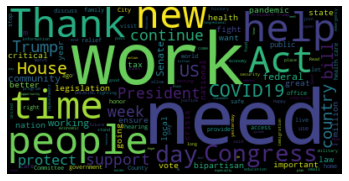

In [307]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [308]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['tokens']

0      Thank Blake gave impassioned speech place expe...
1       My Twitter Town Hall begun I m live Please hit w
2      ‘ fight civil equality important history deepl...
3      There better time We role play protecting Eart...
4      I understand recruiting qualified I m working ...
                             ...                        
942    Thank air traffic flight federal contract stan...
943    new community screening available You 97894684...
944    If House courage stand slapdash work product t...
945    It important support promote public health pro...
946    It argument giving medical trust tax People wi...
Name: tokens, Length: 947, dtype: object

/Users/joseaveldanes/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


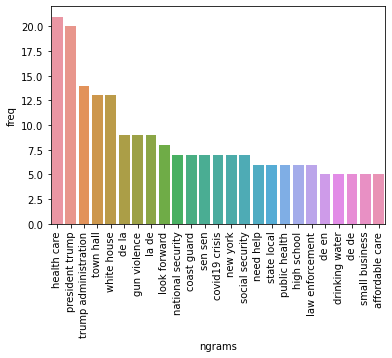

In [309]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()


### EDA 2: Length and Word Count

In [18]:
congress_tweets['tweet_len'] = congress_tweets['tokens'].apply(len)
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))

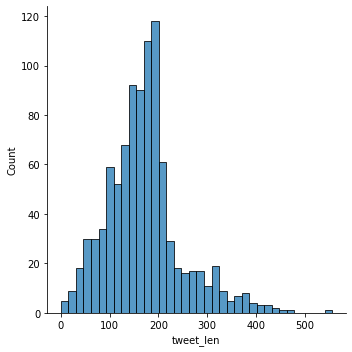

In [19]:
sns.displot(congress_tweets, x="tweet_len")
plt.show()

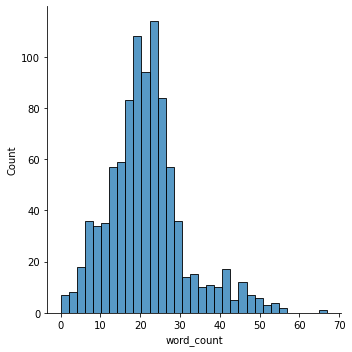

In [20]:
sns.displot(congress_tweets, x="word_count")
plt.show()

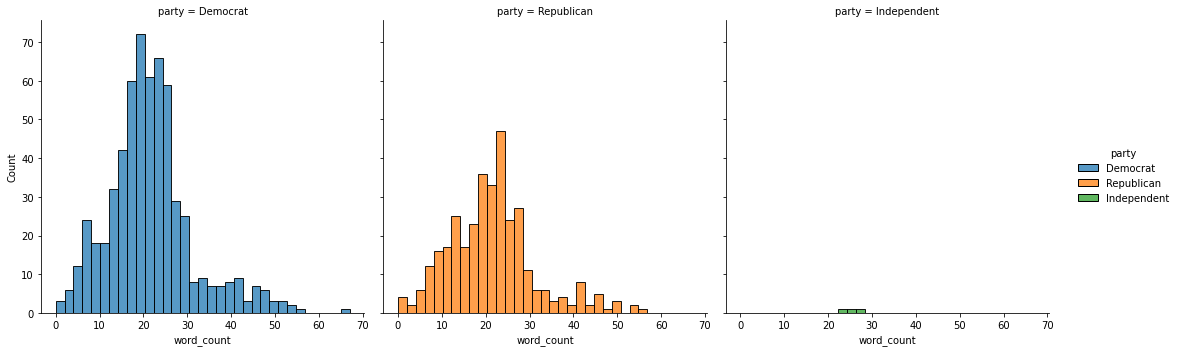

In [21]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

### Topic Modeling

In [22]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [23]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [24]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [25]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
need help    people house health country american legislation water work qt families new bill trump thank president proud federal

Topic #1:
work    time qt house americans families trump people thank — need members “ fill live health public week ”

Topic #2:
   covid19 trump president new qt continue people tax congress protect work workers time security de american – realdonaldtrump need

Topic #3:
act care    local president american crisis bill new health states immigration bipartisan legislation join qt senate ” communities work

Topic #4:
   community help thank trump covid19 happy read day new coronavirus house qt    senate act funding visit passed nt



In [26]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03879515, 0.03873616, 0.84477148, 0.03888735, 0.03880986],
       [0.04653062, 0.04660462, 0.04657066, 0.81307375, 0.04722035],
       [0.03579373, 0.03556939, 0.03543182, 0.0357594 , 0.85744567],
       ...,
       [0.04048231, 0.83764868, 0.04055403, 0.04061872, 0.04069626],
       [0.04114453, 0.83508547, 0.0418992 , 0.04105194, 0.04081885],
       [0.85297731, 0.036546  , 0.03721208, 0.03677962, 0.03648498]])

In [27]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,level_0,index,tweet_id,screen_name,datetime,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count
0,0.038795,0.038736,0.844771,0.038887,0.038810,0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,...,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,Thank testifying Mr Blake QT JRBlake RepValDem...,135,19
1,0.046531,0.046605,0.046571,0.813074,0.047220,1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,...,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,My Twitter Town Hall healthcare begun I m answ...,87,15
2,0.035794,0.035569,0.035432,0.035759,0.857446,2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,...,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,Scipio Jones ‘ fight civil rights equality imp...,167,24
3,0.047729,0.047400,0.810332,0.047250,0.047288,3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,...,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,There better time ActOnClimate EarthDay We rol...,105,14
4,0.041667,0.042028,0.041524,0.833116,0.041665,4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,...,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,I understand VA problems recruiting qualified ...,138,19


In [28]:
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.307087
Democrat       0.223262
Republican     0.204746
Name: 0, dtype: float64
party
Independent    0.584746
Republican     0.192466
Democrat       0.185910
Name: 1, dtype: float64
party
Republican     0.209667
Democrat       0.192422
Independent    0.036031
Name: 2, dtype: float64
party
Democrat       0.184513
Republican     0.159293
Independent    0.035920
Name: 3, dtype: float64
party
Republican     0.233828
Democrat       0.213893
Independent    0.036216
Name: 4, dtype: float64


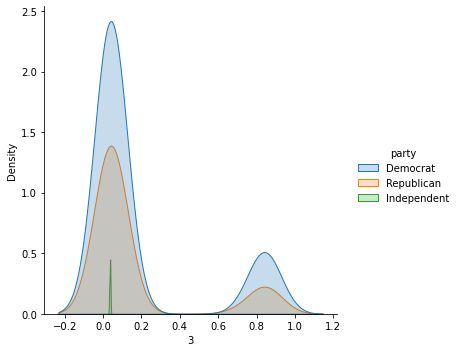

In [29]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "party", kind = 'kde', fill = 'true')
plt.show()

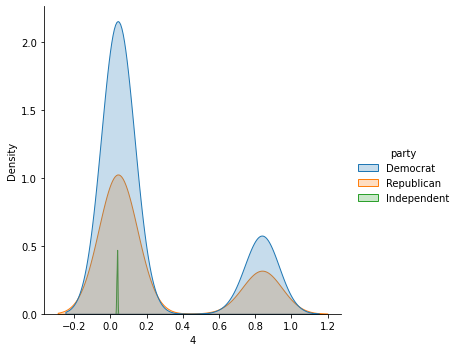

In [30]:
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## 5. Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 5.1: Tammy Duckworth (D-IL) vs. Ted Cruz (R-TX)

In [31]:
#Ted Cruz and Tammy Duckworth Tweets
cruz_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Cruz']
duckworth_tweets = congress_tweets[congress_tweets.name_wikipedia == "Tammy Duckworth"]

#Combining dataframes
cruz_duck_df = [cruz_tweets, duckworth_tweets]
cruz_duck_tweets = pd.concat(cruz_duck_df)

#Polarity and Subjectivity
cruz_duck_tweets['polarity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cruz_duck_tweets['subjectivity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

cruz_duck_tweets.head(25)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity
57,820487,1.279160e+18,SenTedCruz,2020-07-03T17:11:55-04:00,"This weekend, we celebrate the birth of our na...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","This weekend, we celebrate the birth of our na...",This weekend celebrate birth nation gift indep...,153,20,0.000000,0.000000
238,811947,1.256300e+18,SenTedCruz,2020-05-01T15:29:55-04:00,RT @EricTrump Challenge accepted @SeanHannity!...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",RT @EricTrump Challenge accepted @SeanHannity!...,EricTrump Challenge accepted SeanHannity Along...,412,54,0.500000,0.600000
705,797929,1.220850e+18,SenTedCruz,2020-01-24T18:29:25-05:00,My thoughts &amp; prayers are with the familie...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",My thoughts &amp; prayers are with the familie...,My thoughts prayers families 2 Houstonians liv...,406,47,-0.059524,0.238095
755,787860,1.187810e+18,SenTedCruz,2019-10-25T15:26:23-04:00,It’s time for Congress and the American people...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",It’s time for Congress and the American people...,It time Congress American people hear directly...,160,25,0.150000,0.225000
823,760177,1.088950e+18,SenTedCruz,2019-01-25T18:47:06-05:00,"Yesterday, I fought hard to immediately pay ev...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","Yesterday, I fought hard to immediately pay ev...",Yesterday I fought hard immediately pay single...,193,28,-0.090774,0.338988
49,275506,1.104010e+18,SenDuckworth,2019-03-08T08:29:02-05:00,After my father lost his job when I was a teen...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,"2,146,015","3,090,729","3,019,512","2,135,216",After my father lost his job when I was a teen...,After father lost job I teenager food stamps r...,156,23,0.000000,0.000000
291,300399,1.267590e+18,SenDuckworth,2020-06-01T18:39:18-04:00,For Chicago Public School students in need of ...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,"2,146,015","3,090,729","3,019,512","2,135,216",For Chicago Public School students in need of ...,For Chicago Public School students need food F...,332,46,0.000000,0.066667
418,277686,1.120440e+18,SenDuckworth,2019-04-22T17:21:32-04:00,RT @thehill NEW: Dem senators launch Environme...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,"2,146,015","3,090,729","3,019,512","2,135,216",RT @thehill NEW: Dem senators launch Environme...,thehill NEW Dem senators launch Environmental ...,70,10,0.136364,0.454545
560,274612,1.098000e+18,SenDuckworth,2019-02-19T18:12:33-05:00,Depriving Victor Valladares Diaz of his prosth...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,"2,146,015","3,090,729","3,019,512","2,135,216",Depriving Victor Valladares Diaz of his prosth...,Depriving Victor Valladares Diaz prosthetic li...,311,39,-0.090000,0.305000
567,280922,1.142460e+18,SenDuckworth,2019-06-22T12:01:02-04:00,"Three years ago today, days after the horrific...",Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,"2,146,015","3,090,729","3,019,512","2,135,216","Three years ago today, days after the horrific...",Three years ago days horrific PulseShooting do...,213,29,-0.500000,0.500000


### Polarity

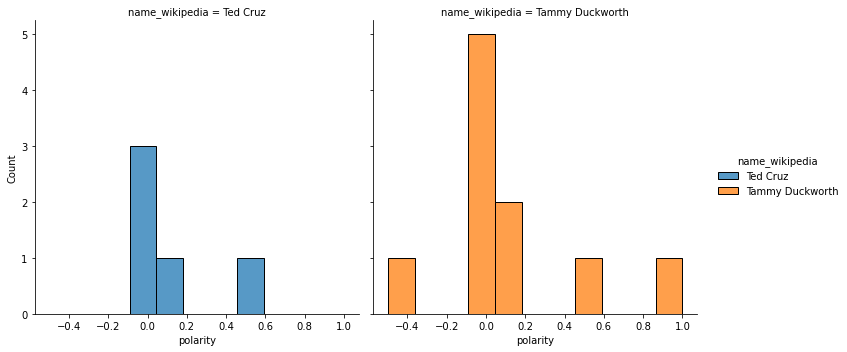

In [32]:
sns.displot(cruz_duck_tweets, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest polarity

**Tammy Duckworth:**

In [33]:
duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in duckworth_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

We can do so much more to help survivors of breast cancer return to health and achieve the best quality of life. That's why I'm introducing the Breast Cancer Patient Equity Act with @lisamurkowski, @RepJudyChu &amp; @RepWalorski https://www.duckworth.senate.gov/news/press-releases/-duckworth-murkowski-chu-and-walorski-re-introduce-bipartisan-bicameral-bill-to-expand-coverage-for-breast-cancer-patients-and-survivors



<ipython-input-33-647af7a0291e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


**Ted Cruz:**

In [34]:
cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in cruz_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-34-0809f2072989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


### Tweets with the smallest polarity

**Tammy Duckworth:**

In [35]:
for tweets in duckworth_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Three years ago today, days after the horrific #PulseShooting, dozens of Congresspeople led by civil rights hero @repjohnlewis gathered on the House floor to stage an historic, 25-hour sit-in demanding a House vote to #EndGunViolence &amp; an end to GOP efforts to block those votes.



**Ted Cruz:**

In [36]:
for tweets in cruz_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Yesterday, I fought hard to immediately pay every single essential federal employee – every essential employee at the Coast Guard, the TSA, air traffic controllers, Border Patrol agents, ICE agents, FBI agents, and those throughout law enforcement.



### Subjectivity

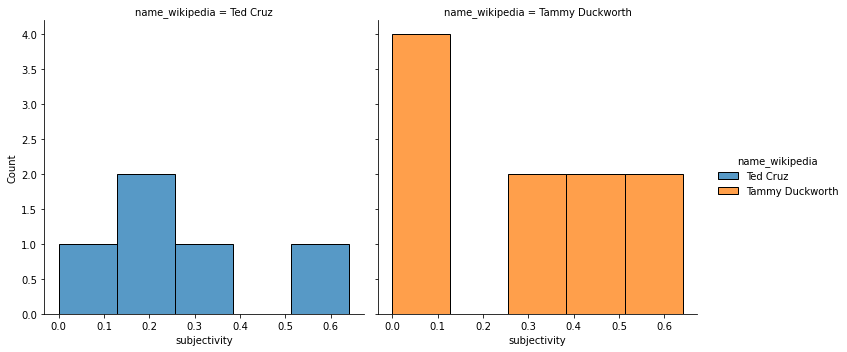

In [37]:
sns.displot(cruz_duck_tweets, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest subjectivity

**Tammy Duckworth:**

In [38]:
duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in duckworth_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweets + "\n")

I will keep working to ensure every family in America – no matter where they live – has access to clean and safe drinking water, and I’m proud to introduce this bill with @RepDanKildee to better protect our children from lead-contaminated water. https://www.duckworth.senate.gov/news/press-releases/07/11/2019/duckworth-kildee-re-introduce-legislation-to-help-protect-families-from-lead-contaminated-water



<ipython-input-38-5401f4840256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


**Ted Cruz**

In [39]:
cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in cruz_tweets.nlargest(1, "subjectivity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-39-d66c643106dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### Tweets with the smallest subjectivity

**Tammy Duckworth:**

In [40]:
for tweets in duckworth_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

After my father lost his job when I was a teenager, food stamps and reduced price meals at school helped keep me from going hungry. I wasn’t alone, either: millions of children across our nation rely on #SchoolBreakfast and other nutritious meals too.



**Ted Cruz:**

In [41]:
for tweets in cruz_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

This weekend, we celebrate the birth of our nation and the gift of independence. Throughout the history of mankind, freedom has been the exception. And yet, here in America, freedom has been delivered and defended for every man, women, and child.



### Sujectivity vs. Polarity

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

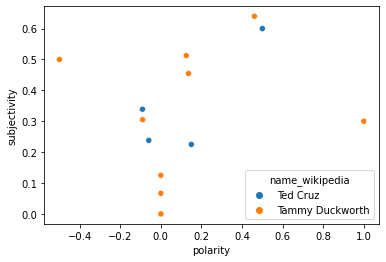

In [42]:
sns.scatterplot(x = cruz_duck_tweets['polarity'], y = cruz_duck_tweets['subjectivity'], hue = cruz_duck_tweets['name_wikipedia'])

### 5.2: Party Affiliation and Bodies of Congress

### Polarity 

In [43]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

**Party Affiliation**

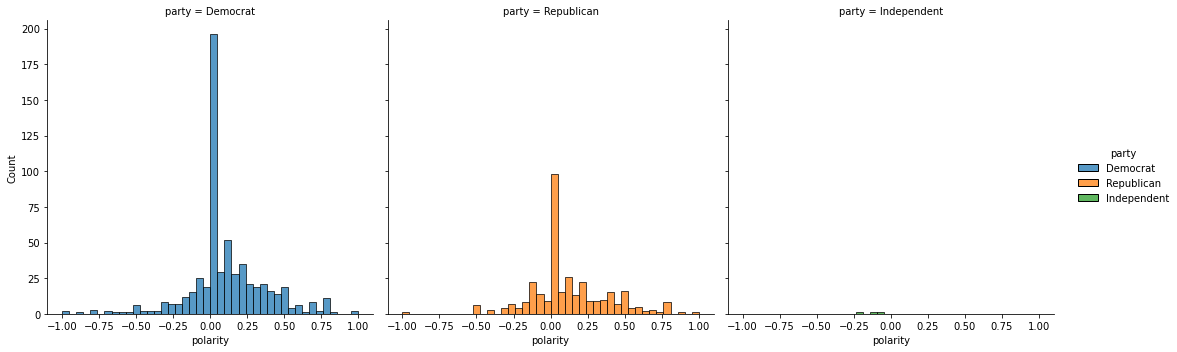

In [44]:
#By Party
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

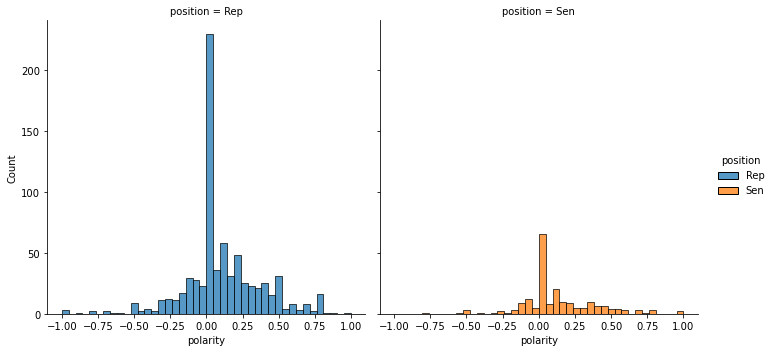

In [45]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

### Subjectivity

In [46]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

**Party Affiliation**

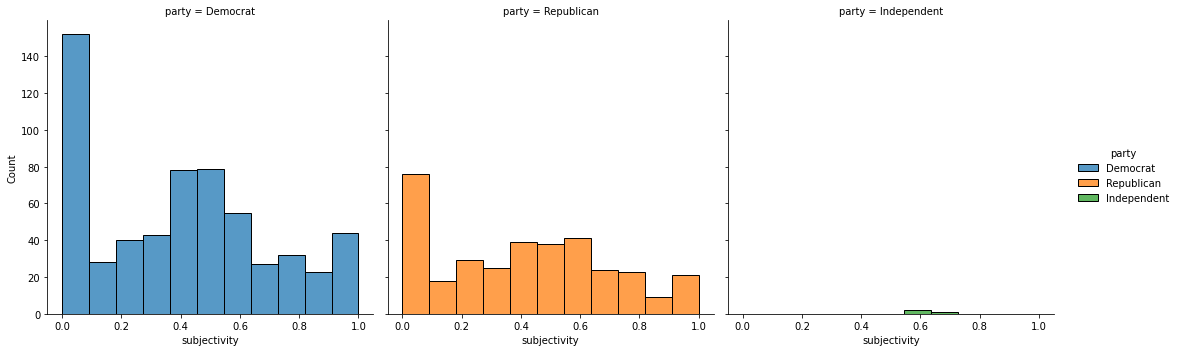

In [47]:
#by party
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

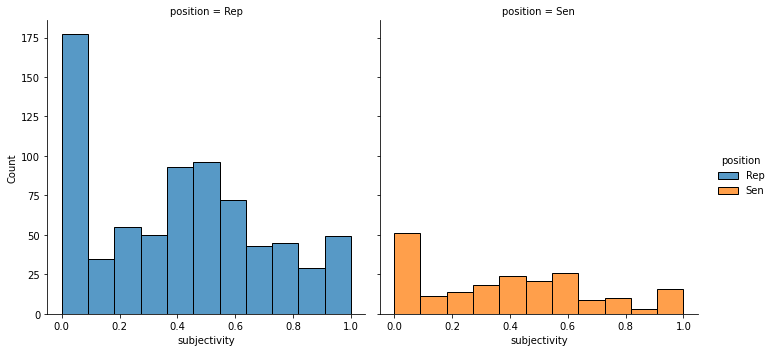

In [48]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## 6. Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [49]:
congress_tweets.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'text_deEmojify', 'tokens', 'tweet_len',
       'word_count', 'polarity', 'subjectivity'],
      dtype='object')

### Engineered Text Features

In [50]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

In [51]:
# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [52]:
# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date','gender', 'state','trump_2016_state_share', 
                                     'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

In [53]:
# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

### Tf-idf 

In [54]:
# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

### Dictionary with top 25 n-grams

In [55]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

/Users/joseaveldanes/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,health care,president trump,american people,small businesses,united states,trump administration,town hall,years ago,white house,house passed,...,social security,covid19 crisis,national security,coast guard,coronavirus relief,men women,high school,state local,qt thehill,millions americans
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

### Embedding Based Featurization

In [178]:
#Converting from string back to list
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0      [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
1      [My, Twitter, Town, Hall, healthcare, begun, I...
2      [Scipio, Jones, ‘, fight, civil, rights, equal...
3      [There, better, time, ActOnClimate, EarthDay, ...
4      [I, understand, VA, problems, recruiting, qual...
                             ...                        
942    [Thank, air, traffic, controllers, flight, att...
943    [LawrenceGenHosp, new, coronavirus, community,...
944    [senatemajldr, If, House, musters, courage, st...
945    [It, important, support, policies, promote, pu...
946    [davidmgoodwin, CDCgov, It, argument, giving, ...
Name: tokens, Length: 947, dtype: object

In [58]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

FileNotFoundError: [Errno 2] No such file or directory: 'data/GoogleNews-vectors-negative300.bin.gz'

In [ ]:
# retrain congress_tweets['tokens'] model so it has the same dimensions as the google vector
word2vec_model = gensim.models.Word2Vec(size = 300, window=5, min_count = 1, workers = 3)
 
word2vec_model.build_vocab(congress_tweets['tokens'])
 
# set lockf = 1 to allow updating
 
word2vec_model.intersect_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
 
# Finish training model
word2vec_model.train(congress_tweets['tokens'], total_examples=3, epochs = 5)

In [ ]:
words = list(word2vec_model.wv.vocab)
print(words[0:100])

In [ ]:
doc = [word for word in congress_tweets['tokens'][0] if word in word2vec_model.wv.vocab]
len(doc)

In [ ]:
first_vec = []
for token in word2vec_model.wv.__getitem__(doc):
    first_vec.append(token[0])
numpy.mean(first_vec)

In [ ]:
def document_vector(word2vec_model, doc):
    doc = [word for word in congress_tweets['tokens'][0] if word in word2vec_model.wv.vocab]
    return numpy.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [ ]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, doc))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array

In [ ]:
doc_average_embeddings

In [ ]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## 7. Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
congress_tweets.loc[congress_tweets['party'] == "Independent"]

In [ ]:
congress_tweets['ReporDem'] = congress_tweets['party'].apply(lambda x: 0 if x=='Democrat' and x!='Independent' else 1)
congress_tweets.head()

In [ ]:
congress_tweets.dtypes

In [ ]:
X

In [ ]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date',
       'gender', 'state','trump_2016_state_share', 'clinton_2016_state_share']]

non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

In [ ]:
non_text_features_dummies

In [ ]:
##train the Y and do the thing you need to do 
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams,
            word2vec_features_df]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features',
                          'word2vec_features_df']

                          
lb_style = LabelBinarizer()
y = lb_style.fit_transform(congress_tweets["ReporDem"])

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

##There are the first three models with democrat and republican 
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression(max_iter=200)
    
    # fit the model
    #logit_model = logit_reg_extra.fit(X_train, y_train.ravel())
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat Tweet", 1: "Republican Tweet"})
    df_cm.index = ["Democrat Tweet", "Republican Tweet"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
congress_tweets.head()

In [ ]:
sns.scatterplot(x = congress_tweets['polarity'], y = congress_tweets['subjectivity'], hue = congress_tweets['ReporDem'])

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])


...

## 8. Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**

### PCA

In [ ]:
#X = word2vec_model.wv.__getitem__(word2vec_model.wv.vocab)

In [ ]:
# scale the data
#X_std = StandardScaler().fit_transform(X)

In [ ]:
# make a PCA
#pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
#Y_pca = pca.fit_transform(X_std)

In [ ]:
#sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

In [ ]:
#import random
#random.seed(10)
#rando = random.sample(list(model.wv.vocab), 25)

#X1 = model.wv.__getitem__(rando)
#pca1 = PCA(n_components=2)
#result = pca.fit_transform(X1)
#result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
#sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

#from adjustText import adjust_text
#texts = []

# Append words to list
#for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
#adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

#plt.show()

In [ ]:
# Engineered Text Features
#engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
#engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
#non_text_features = congress_tweets[['position', 'joined_congress_date','gender', 'state','trump_2016_state_share', 'clinton_2016_state_share',
                                    'obama_2012_state_share', 'romney_2012_state_share']]
#removing party

#non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)


# Non-text features + engineered features
#non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
#tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
#non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
#non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

In [ ]:
#dataframes = [engineered_features, 
             # engineered_features_with_topics,
              #non_text_features_dummies,
              #non_text_engineered_features,
              #tfidf_df, 
              #non_text_plus_tfidf,
             #top_25_ngrams,
            # non_text_with_ngrams,
            # word2vec_features_df]

#featurization_technique = ['Engineered Text Features',
                         #   'Engineered Features + Topic Model',
                          # 'Non-Text Features',
                          # 'Non-Text + Engineered Text Features',
                          # 'Tf-idf Features',
                          # 'Non-Text + Tf-idf Features',
                          #'Top 25 N-Gram Features',
                          #'Non-Text + Top 25 N-Gram Features',
                          #'word2vec_features_df']

#Average Word Embeddings Classification

#y = congress_tweets["ReporDem"]

#X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
# create a model
#logit_reg = LogisticRegression()

# fit the model
#logit_model = logit_reg.fit(X_train, y_train.ravel())

#y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()